# Whole brain data processing -- Mask check

## This code serves for checking mask while local denoising is performed

In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from cellProcessing import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Set up environments

* Install `fish_proc` from github https://github.com/zqwei/fish_processing

In [2]:
## STEP 1: specify data and save path
dir_root = '/groups/ahrens/ahrenslab/jing/giving_up/20190219/fish2/7dpf-huc_gcamp7ff_gfap_rgeco-GU_slow_fwd-fish02-exp02_20190219_174013/im'
# save_root = '/nrs/ahrens/jing/20190219/fish2/7dpf-huc_gcamp7ff_gfap_rgeco-GU_slow_fwd-fish02-exp02_20190219_174013/processed'

### Set save folder to Ziqiang's folder

In [3]:
save_root = './processed'
if not os.path.exists(save_root):
    os.makedirs(save_root)

## Mask

In [4]:
Y_d_ave_ = da.from_zarr(f'{save_root}/Y_ave.zarr').rechunk((1, -1, -1, -1))

In [5]:
intensity_percentile = 50
mask =  Y_d_ave_.map_blocks(lambda v: intesity_mask(v, percentile=intensity_percentile), dtype='bool').compute()

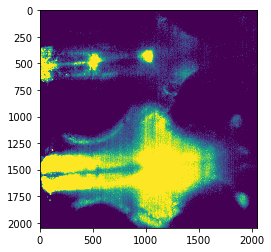

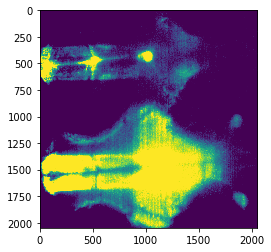

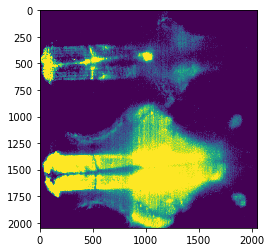

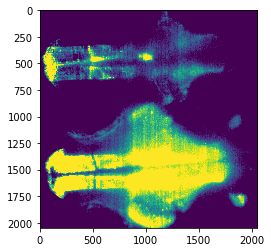

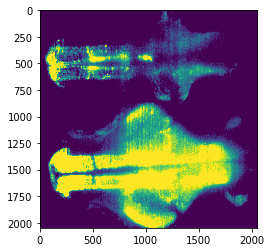

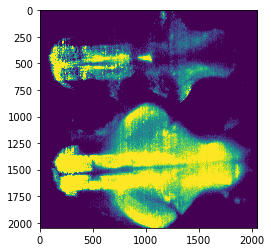

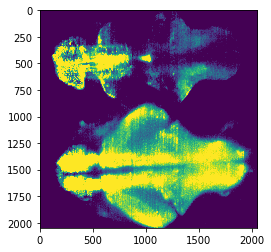

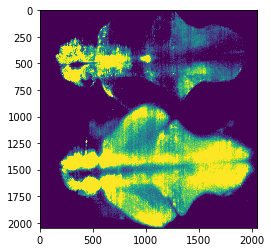

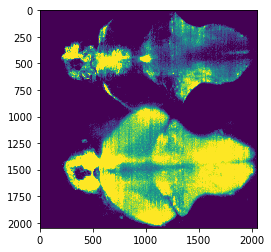

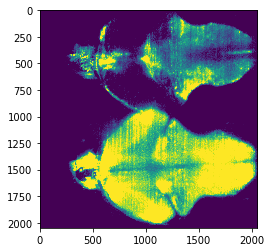

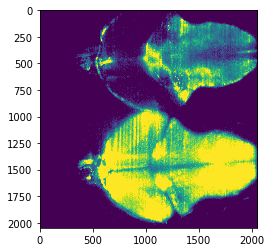

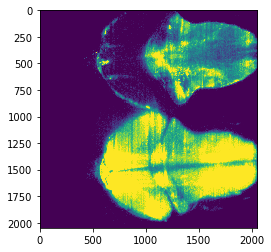

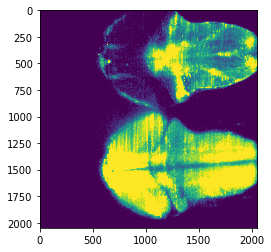

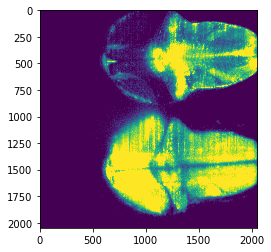

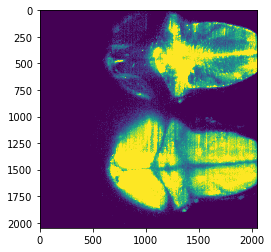

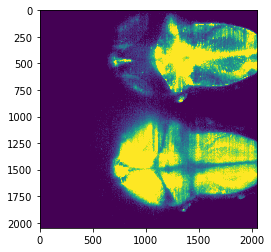

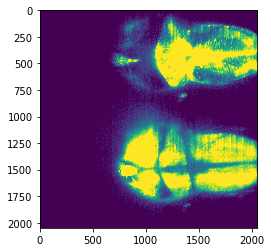

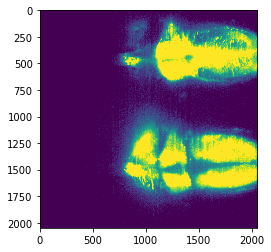

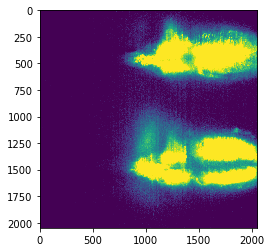

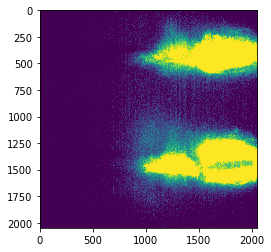

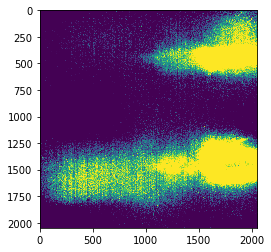

In [6]:
for n_ave_ in Y_d_ave_.squeeze():
    plt.imshow(n_ave_, vmax=np.percentile(n_ave_, 90), vmin=np.percentile(n_ave_, intensity_percentile))
    plt.show()